In [20]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
#define the plot function on the first 5 images in testloader, and out put the overall miou on the entire testdata
import torch
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Cast to long to prevent overflow
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        
        if union != 0:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious, np.mean(ious)

def visualize_predictions(model, test_loader, device, num_examples=5, num_classes=21, title=''):
    model.eval()
    test_images, test_masks, test_predictions = [], [], []
    all_ious = []
    mean_ious = []

    with torch.no_grad():
        for i, (images, masks, _) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            if i < num_examples:
                test_images.append(images.cpu()[0])
                test_masks.append(masks.cpu()[0])
                test_predictions.append(preds.cpu()[0])

            # Calculate IoU and mIoU
            ious, mean_iou = calculate_iou(preds.cpu(), masks.cpu(), num_classes)
            all_ious.append(ious)
            mean_ious.append(mean_iou)

    # Calculate overall mIoU
    overall_miou = np.mean(mean_ious)

    # Plotting the results
    fig, axs = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    for i in range(num_examples):
        axs[i, 0].imshow(test_images[i].permute(1, 2, 0))
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(test_masks[i], cmap='tab20', vmin=0, vmax=num_classes-1)
        axs[i, 1].set_title("Ground Truth Mask")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(test_predictions[i], cmap='tab20', vmin=0, vmax=num_classes-1)
        axs[i, 2].set_title("Predicted Mask")
        axs[i, 2].axis('off')

    fig.suptitle(f'Performance on {title}\nOverall mIoU: {100*overall_miou:.2f}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

In [22]:
#define the function to plot the iou on each labels
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_iou_per_class(pred, target, num_classes):
    ious = np.zeros(num_classes)
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Cast to long to prevent overflow
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        
        if union != 0:
            ious[cls] = float(intersection) / float(max(union, 1))
    return ious

def evaluate_model_performance(model, test_loader, device, num_classes):
    model.eval()
    class_ious = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            ious = calculate_iou_per_class(preds.cpu(), masks.cpu(), num_classes)
            class_ious += ious
            num_batches += 1

    class_ious /= num_batches
    return class_ious

def plot_iou_table(class_ious, class_labels, method_name):
    # Create a DataFrame for better visualization
    df = pd.DataFrame({'Class': class_labels, 'IoU': class_ious})
    df.loc['mIoU'] = ['Overall mIoU', np.mean(class_ious)]
    
    # Plotting the table
    fig, ax = plt.subplots(figsize=(12, 8)) # set size frame
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center', colColours =["palegreen"] * df.shape[1])
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    the_table.scale(1.2, 1.2)
    plt.title(f'IoU for each class - {method_name}', fontsize=16)
    plt.show()

In [23]:
# METAINFO dictionary as provided
METAINFO = {
    "classes": (
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush",
        "fence",
        "structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (230, 25, 75),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (250, 190, 190),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Create mapping dictionaries
palette_to_cidx = {tuple(rgb): idx for idx, rgb in enumerate(METAINFO['palette'])}
num_classes = len(palette_to_cidx)

In [24]:
class JointTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, image, mask):
        # Apply the base transform to the image
        image = self.base_transform(image)
        # Resize mask without using the base transform
        mask = mask.resize((256, 256), Image.NEAREST)
        # Convert mask to numpy array
        mask = np.array(mask)
        # Map RGB values to class indices
        mask = np.apply_along_axis(lambda x: palette_to_cidx.get(tuple(x), 0), 2, mask)  # <--- Changed
        # Ensure mask is of shape [height, width]
        mask = mask.astype(np.int64)
        # Convert mask to tensor
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

class SegmentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir.rstrip('/') + '/'
        self.transform = transform
        self.binary_attrs = ['dirt', 'mud', 'water', 'gravel', 'other-terrain', 'tree-trunk', 'tree-foliage',
                             'bush', 'fence', 'structure', 'pole', 'vehicle', 'rock', 'log', 'other-object', 'sky', 'grass']

        # Preload all images and masks
        self.images = []
        self.masks = []
        self.attributes = []
        self._load_data()

    def _load_data(self):
        for idx in range(len(self.data_frame)):
            image_path = self.root_dir + self.data_frame.iloc[idx]['im_path'].lstrip('/')
            mask_path = self.root_dir + self.data_frame.iloc[idx]['label_path'].lstrip('/')

            # Check if the files exist
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found: {image_path}")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask file not found: {mask_path}")

            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("RGB")  # Keep as RGB to map to class indices

            if self.transform:
                image, mask = self.transform(image, mask)

            attributes = self.data_frame.iloc[idx][self.binary_attrs].values.astype(int)

            self.images.append(image)
            self.masks.append(mask)
            self.attributes.append(attributes)

            # Print message to indicate processing of each image
            print(f"Processed image {idx + 1}/{len(self.data_frame)}: {image_path}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx], self.attributes[idx]

In [25]:
#load the test data
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms
# Define the transformations
base_transform = transforms.Compose([
    transforms.Resize((512, 512)),  
    transforms.ToTensor(),          # Convert images to tensors
])

joint_transform = JointTransform(base_transform)

# Normalize images separately
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Paths to the CSV files

test_csv = './test.csv'

# Root folder for the images and masks
root_folder = './'

# Instantiate the datasets

test_dataset = SegmentationDataset(test_csv, root_folder, transform=joint_transform)

# Create DataLoaders

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) 


Processed image 1/227: ././sample/images\1623370412-986500272.png
Processed image 2/227: ././sample/images\1623370438-443034581.png
Processed image 3/227: ././sample/images\1623370461-764772906.png
Processed image 4/227: ././sample/images\1623370487-755815747.png
Processed image 5/227: ././sample/images\1623370505-780336399.png
Processed image 6/227: ././sample/images\1623370528-826680615.png
Processed image 7/227: ././sample/images\1623370555-358916479.png
Processed image 8/227: ././sample/images\1623370583-030297326.png
Processed image 9/227: ././sample/images\1623370602-996388272.png
Processed image 10/227: ././sample/images\1623370622-292488909.png
Processed image 11/227: ././sample/images\1623370640-449779203.png
Processed image 12/227: ././sample/images\1623370657-869689326.png
Processed image 13/227: ././sample/images\1623370701-017993419.png
Processed image 14/227: ././sample/images\1623370727-684502808.png
Processed image 15/227: ././sample/images\1623370746-779743969.png
Proc

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, C, H, W = x.shape  # 4D input
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)  # Flatten spatial dimensions and permute to [B, N, C]
        qkv = self.qkv(x).reshape(B, -1, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, -1, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2)  # Convert back to 4D
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, -1, C)  # Flatten spatial dimensions and permute to [B, N, C]
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2)  # Convert back to 4D
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity() if drop_path == 0 else DropPath(drop_path)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.drop_path(self.attn(x))
        x = self.norm2(x)
        x = x + self.drop_path(self.mlp(x))
        return x

class SegFormerBackboneB0(nn.Module):
    def __init__(self, num_classes):
        super(SegFormerBackboneB0, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d),
            Block(dim=64, num_heads=1, norm_layer=nn.BatchNorm2d)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d),
            Block(dim=128, num_heads=2, norm_layer=nn.BatchNorm2d)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d),
            Block(dim=256, num_heads=4, norm_layer=nn.BatchNorm2d)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x1, x2, x3, x4

class SegFormerB0(nn.Module):
    def __init__(self, num_classes):
        super(SegFormerB0, self).__init__()
        self.backbone = SegFormerBackboneB0(num_classes)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1, x2, x3, x4 = self.backbone(x)
        output = self.decoder(x4)
        output = F.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)  # Upsample to match target size
        return output

# Define the loss function and optimizer for SegFormerB0
num_classes = 21  # Adjust the number of classes according to your dataset
segformer_model = SegFormerB0(num_classes=num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')
segformer_criterion = nn.CrossEntropyLoss()
segformer_optimizer = torch.optim.Adam(segformer_model.parameters(), lr=1e-4)

# Load the model weights
model_path = './segformer_b0.pth'
segformer_model.load_state_dict(torch.load(model_path))
segformer_model.eval()




SegFormerB0(
  (backbone): SegFormerBackboneB0(
    (encoder1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Block(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False

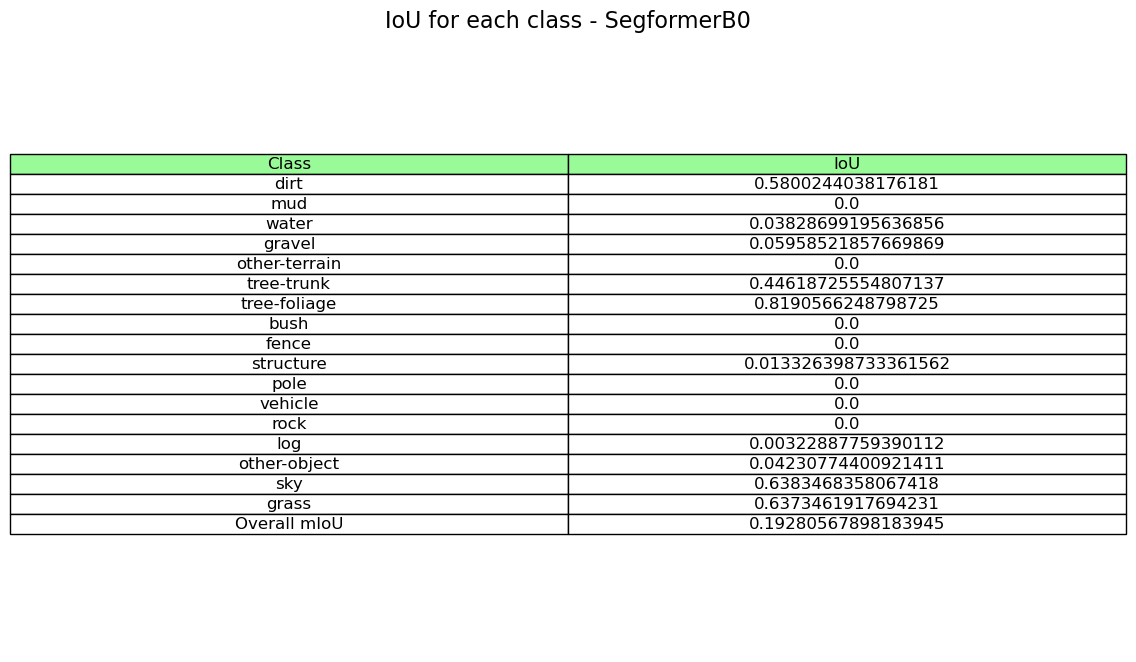

In [27]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_labels = METAINFO["classes"]
num_classes = len(class_labels)

# Assuming you have a test_loader and a trained model
class_ious = evaluate_model_performance(segformer_model, test_loader, device, num_classes=num_classes)
plot_iou_table(class_ious, class_labels, method_name='SegformerB0')

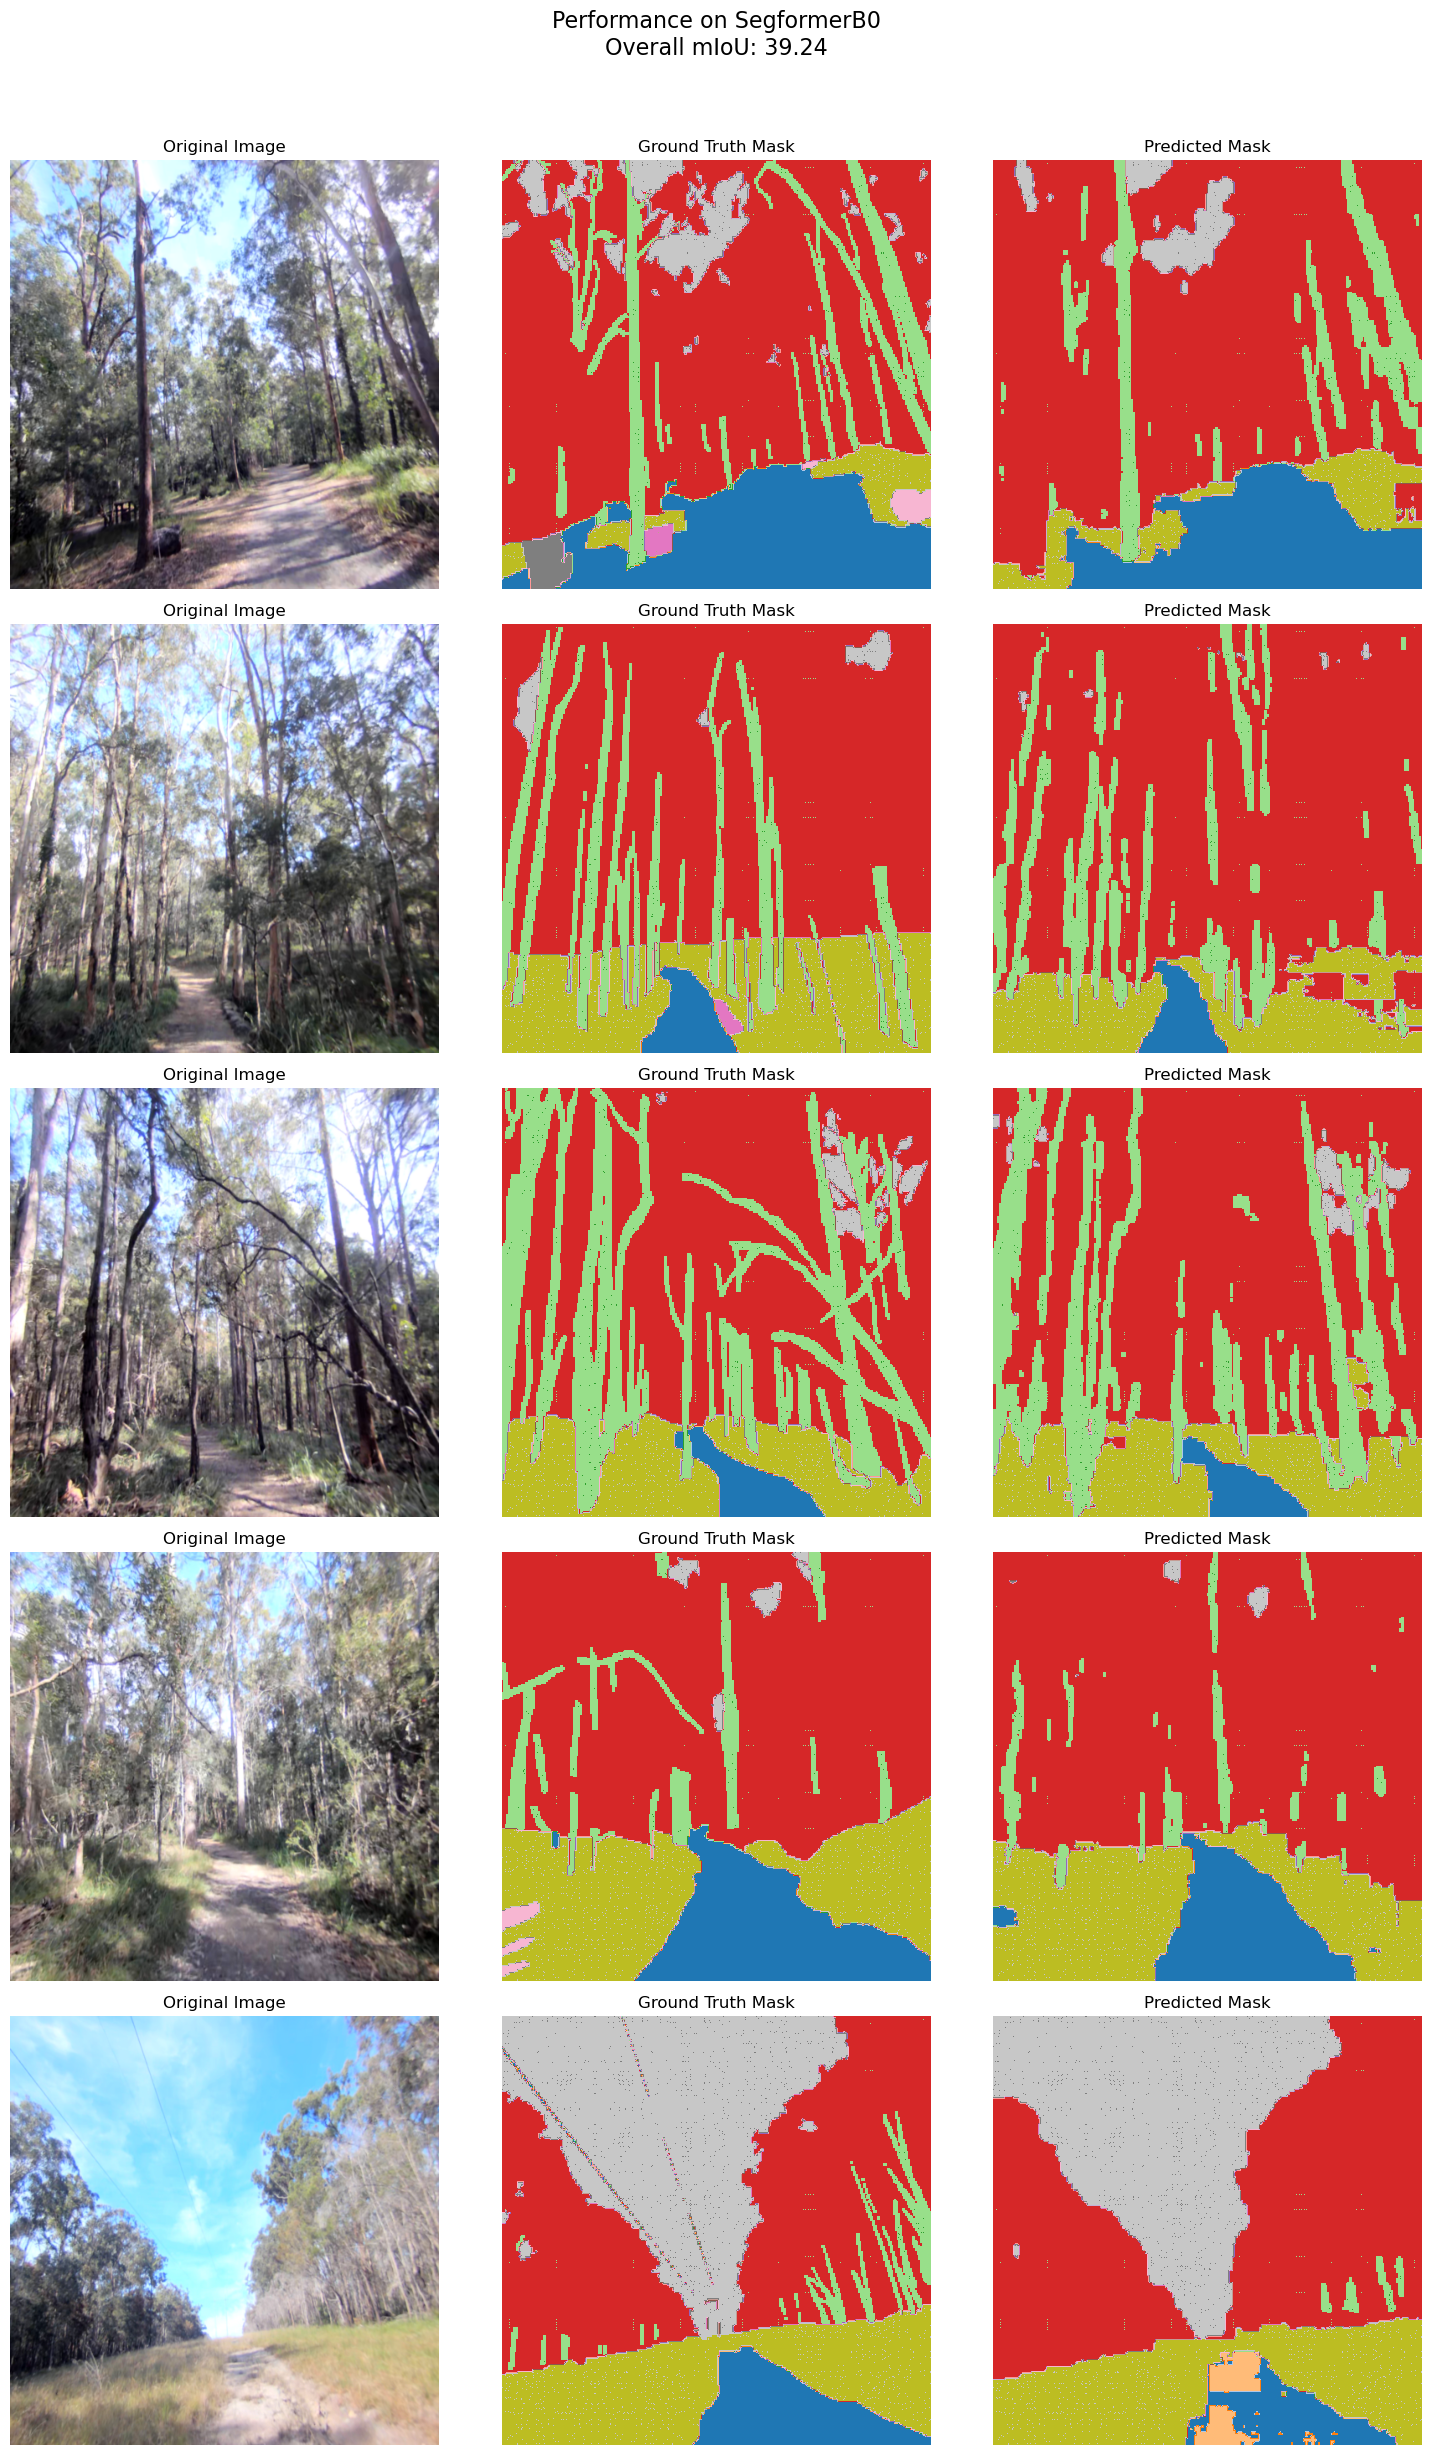

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(segformer_model, test_loader, device, num_examples=5, num_classes=21,title='SegformerB0')